In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 -4*x+5

In [3]:
f(3)

20

In [4]:
xs = np.arange(-5,5,0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [5]:
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

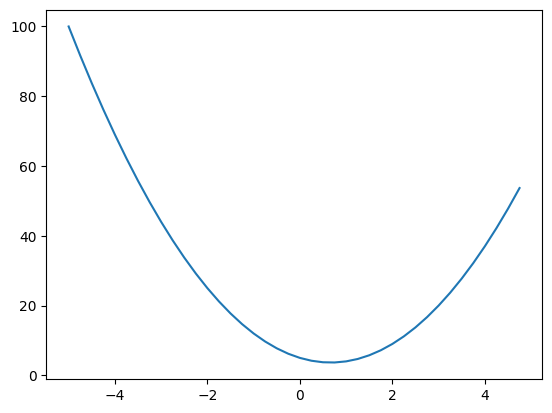

In [6]:
plt.plot(xs,ys)

In [7]:
h = 0.0001
x = -3.0
(f(x+h)-f(x))

-0.0021999700000066014

In [8]:
a = 2.0
b = -3.0
c = 10.0
d1 = a*b +c
c+=h
d2 = a*b +c
print('d1',d1)
print('d2',d2)
print('Slope',(d2-d1)/h)

d1 4.0
d2 4.0001
Slope 0.9999999999976694


In [9]:
class Value:
    def __init__(self,data,_children=(),_op='',label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data, (self,other),'+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self,other):
        return self + other
      
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, (self,other),'*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self,other):
        return self*other
    
    def __pow__(self,other):
        assert isinstance(other,(int,float))
        out = Value(self.data**other,(self,),f'**(other)')
        def _backward():
            self.grad += out.grad * ((other)*(self.data**(other-1)))
        out._backward = _backward
        return out
    
    def __truediv__(self,other):
        return self*other**-1
    
    def __sub__(self,other):
        return self+(-1*other)

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1 - t ** 2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x),(self,),'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad=1.0
        for node in reversed(topo):
            node._backward()
    # now when we assign the value to a new variable not only it containes the values by function but also where did it get the values from
    



In [10]:
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{%s | data %.4f | grad %.4f }" % (n.label , n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [11]:
#inputs
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
#weights
w1 = Value(-3.0,label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432,label='b')

x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'
n = x1w1x2w2 + b; n.label ='n'
o = n.tanh(); o.label='o'



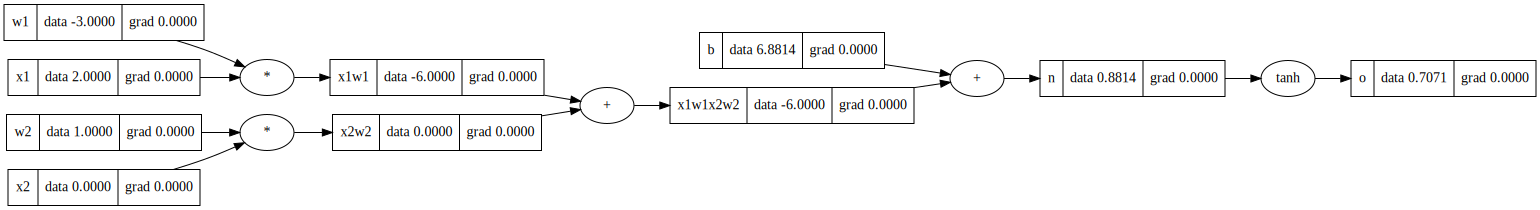

In [12]:
draw_dot(o)

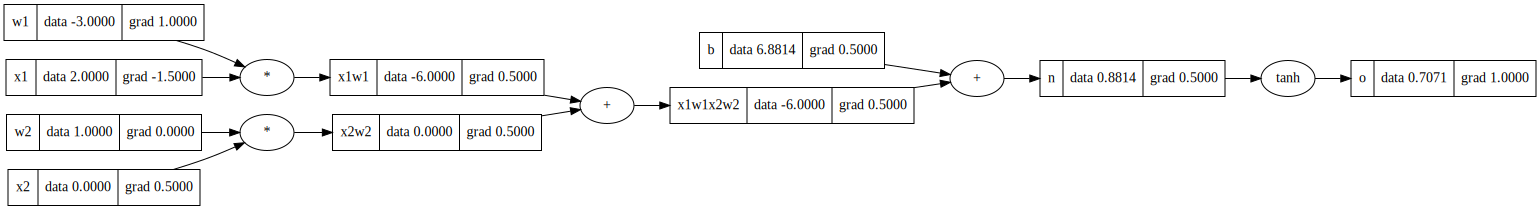

In [13]:
o.backward()
draw_dot(o)

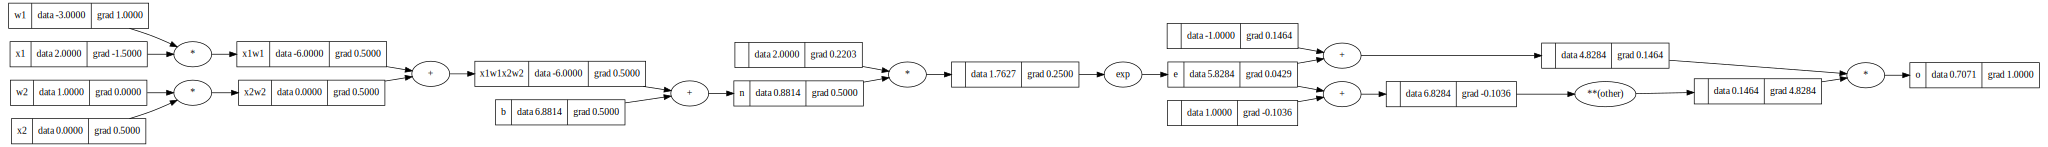

In [14]:
#inputs
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
#weights
w1 = Value(-3.0,label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432,label='b')

x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'
n = x1w1x2w2 + b; n.label ='n'
e = (2*n).exp(); e.label='e'
o = (e-1)/(e+1)
o.label = 'o'
o.backward()
draw_dot(o)



In [48]:
import random
class Neuron:

    def __init__(self,nin):
        self.w = [(Value(random.uniform(-1,1))) for _ in range (nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self,x):
        # Compute the activation as the dot product + bias
        act = sum((wi * xi) for wi, xi in zip(self.w, x)) + self.b
        # Apply the tanh activation function
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:

    def __init__(self,nin,nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]



In [49]:
x = [2.0,3.0,-1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=0.6348884306109653)

In [52]:
xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]
]

ys = [1.0,-1.0,-1.0,1.0]
ypred = [n(x) for x in xs]
ypred

[Value(data=0.6348884306109653),
 Value(data=-0.1719638048538117),
 Value(data=-0.1200046652684968),
 Value(data=0.3287386344385599)]

In [53]:
loss = sum([(yout-ygt)**2 for ygt, yout in zip(ys,ypred)])
loss

Value(data=2.04393400861852)

In [89]:
ypred = [n(x) for x in xs]
loss = sum([(yout-ygt)**2 for ygt, yout in zip(ys,ypred)])
loss

Value(data=0.028452903314535042)

In [90]:
loss.backward()

In [88]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [91]:
ypred

[Value(data=0.9712810067326126),
 Value(data=-0.9479017837403583),
 Value(data=-0.8467419206006298),
 Value(data=0.9622394425144074)]

In [100]:
x = [2.0,3.0,-1.0]
n = MLP(3,[4,4,1])

In [103]:
xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]
]

ys = [1.0,-1.0,-1.0,1.0]



for k in range(20):
    ypred = [n(x) for x in xs]
    loss = sum([(yout-ygt)**2 for ygt, yout in zip(ys,ypred)])

    for p in n.parameters():
        p.grad=0.0

    loss.backward()

    for p in n.parameters():
        p.data += -0.05*p.grad
    
    print(k,loss.data)

0 0.023871307705607074
1 0.02303009887137618
2 0.022240913213530278
3 0.021499275045830046
4 0.020801194559746418
5 0.020143104787867662
6 0.019521808007071328
7 0.018934429988731794
8 0.018378380800693643
9 0.017851321102534623
10 0.017351133065142334
11 0.016875895198042945
12 0.01642386049109521
13 0.01599343737717164
14 0.015583173104003586
15 0.015191739170158208
16 0.014817918535035465
17 0.014460594358113105
18 0.014118740060235158
19 0.013791410530981745
